# Industrial Equipment Anomaly Detection using Autoencoders

This project aims to detect anomalies in industrial equipment using autoencoders. The dataset used for this project is the CMAPSS dataset, which includes multivariate time series data from engine systems. The objective is to predict the remaining useful life (RUL) of the engines and detect


## Imports and Setup

In this section, we import the necessary libraries for data preprocessing, model building, and visualization. Additionally, we define some global settings such as random seeds and file paths.


In [1]:
! pip install numpy pandas scikit-learn tensorflow keras matplotlib seaborn tqdm pydot graphviz


In [2]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import plot_model
from IPython.display import Image

import matplotlib.pyplot as plt
import seaborn as sns
from tqdm.notebook import tqdm  # Progress bar for Jupyter Notebooks


## Load and Preprocess Data

We load the data from the provided CSV files and perform necessary preprocessing steps:
- Fill missing values using forward fill (`ffill`) and backward fill (`bfill`).
- Drop any non-numeric columns.
- Standardize the data using `StandardScaler` to ensure the model performs optimally.

We also implement a loading bar using `tqdm` to track progress during data loading.


In [3]:
def load_and_preprocess_data(file_path, scaler=None):
    data = pd.read_csv(file_path)
    
    # Fill missing values for the entire DataFrame without chained assignments
    data = data.ffill().bfill()
    
    # Drop non-numeric columns if any
    data = data.select_dtypes(include=[np.number])
    
    # Apply scaling
    if scaler is None:
        scaler = StandardScaler()
        data_scaled = scaler.fit_transform(data)
        return data_scaled, scaler
    else:
        data_scaled = scaler.transform(data)
        return data_scaled


## Train/Test Split

After preprocessing the data, we split the dataset into training and validation sets. This allows us to evaluate the model's performance on unseen data during training.


In [4]:
# Load training and testing data
train_data, scaler = load_and_preprocess_data('CMAPSS_CSV/train_FD001.csv')
test_data = load_and_preprocess_data('CMAPSS_CSV/test_FD001.csv', scaler)

# Split training data into training and validation sets
X_train, X_val = train_test_split(train_data, test_size=0.2, random_state=42)


## Autoencoder Model Architecture

The autoencoder is a neural network designed to learn efficient representations of the input data. It consists of two main parts:
- **Encoder**: Reduces the dimensionality of the input data.
- **Decoder**: Reconstructs the data back to its original form.

The model is trained to minimize the reconstruction error (Mean Squared Error - MSE).


In [5]:
# Define the autoencoder model
input_dim = X_train.shape[1]
encoding_dim = 32  # Dimensionality of the encoding layer

input_layer = Input(shape=(input_dim,))
encoded = Dense(encoding_dim, activation='relu')(input_layer)
decoded = Dense(input_dim, activation='sigmoid')(encoded)

autoencoder = Model(input_layer, decoded)
autoencoder.compile(optimizer=Adam(), loss='mse')


## Model Training

We train the autoencoder model using the training data and validate it on the validation set. The training is monitored using an early stopping callback to prevent overfitting.

**Training Parameters:**
- Epochs: 50
- Batch Size: 256
- Early Stopping: Patience of 10 epochs with `restore_best_weights=True`


In [6]:
# Train the autoencoder with early stopping
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
history = autoencoder.fit(X_train, X_train,
                          epochs=50,
                          batch_size=256,
                          shuffle=True,
                          validation_data=(X_val, X_val),
                          callbacks=[early_stopping])

# Save the model
autoencoder.save('autoencoder_model.h5')


Epoch 1/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step - loss: 0.9450 - val_loss: 0.7351
Epoch 2/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.6902 - val_loss: 0.5866
Epoch 3/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5792 - val_loss: 0.5372
Epoch 4/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5401 - val_loss: 0.5113
Epoch 5/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.5136 - val_loss: 0.4951
Epoch 6/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4991 - val_loss: 0.4845
Epoch 7/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - loss: 0.4880 - val_loss: 0.4772
Epoch 8/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4811 - val_loss: 0.4718
Epoch 9/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4796 - val_loss: 0.4677
Epoch 10/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4755 - val_loss: 0.4643
Epoch 11/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4709 - val_loss: 0.4614
Epoch 12/50
65/65 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - loss: 0.4692 - val_lo

###  Model Summary
To get an overview of the autoencoder model's architecture, including the layers and parameters, we use the `summary()` method. This will print a detailed summary of the model's configuration:

In [7]:
autoencoder.summary()


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 26)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 32)             │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 26)             │           858 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,168 (20.19 KB)

 Trainable params: 1,722 (6.73 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 3,446 (13.46 KB)

## Visualizing the Autoencoder Model

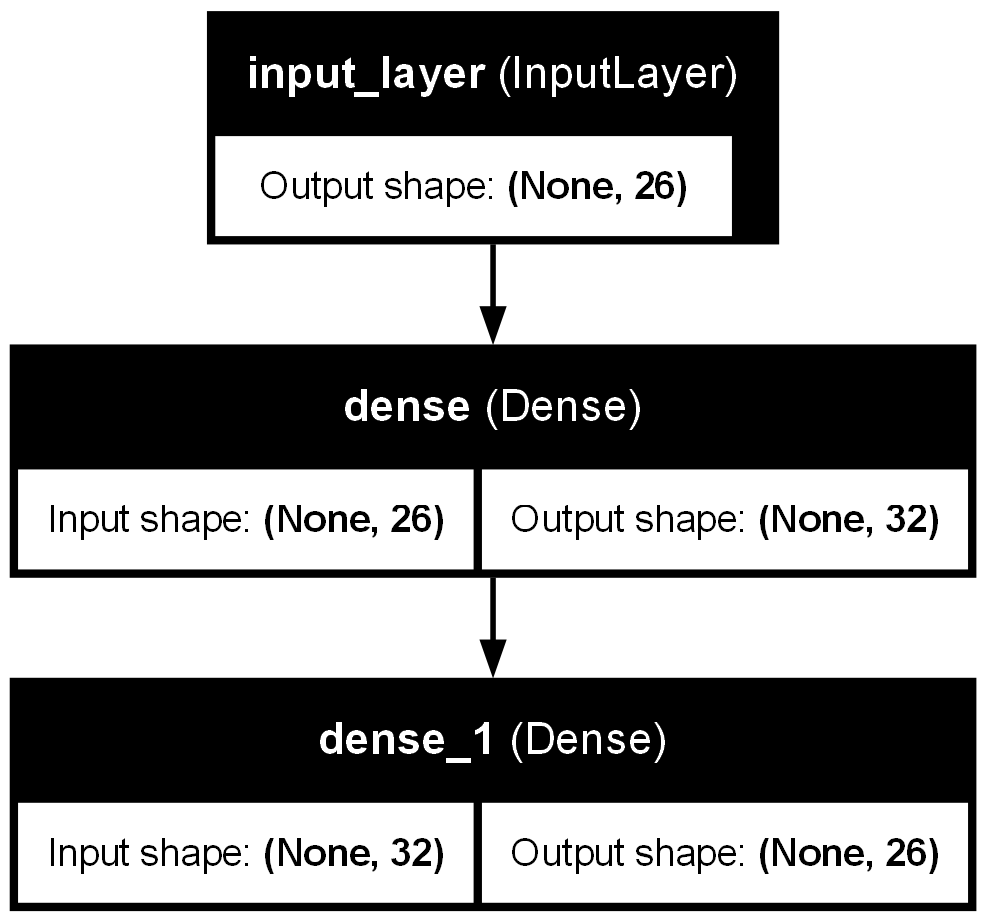

In [8]:
# Ensure Graphviz is properly set up
plot_model(autoencoder, to_file='autoencoder_model_plot.png', show_shapes=True, show_layer_names=True)

# Display the model plot
Image(filename='autoencoder_model_plot.png')


## Model Performance Visualization

After training, we visualize the model's performance by plotting the training and validation loss over epochs. This helps us understand how well the model has learned to reconstruct the data.


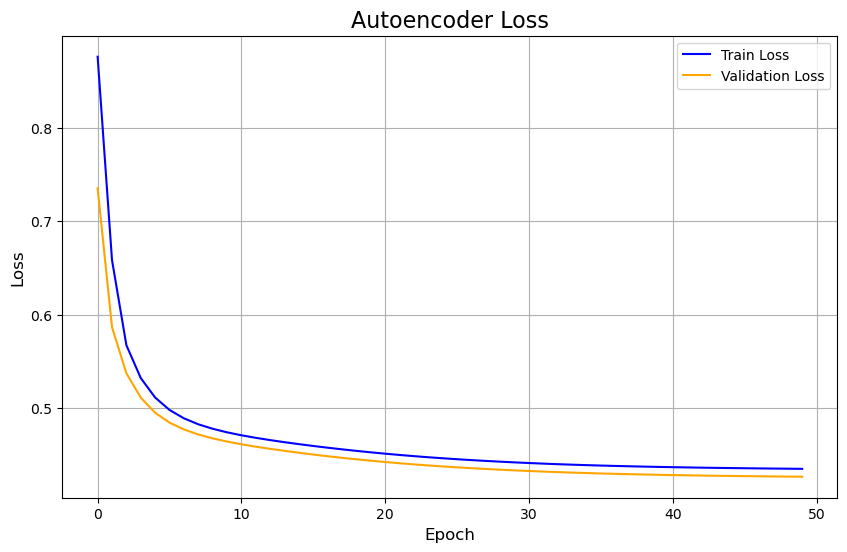

In [9]:
# Plot training & validation loss
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss', color='blue')
plt.plot(history.history['val_loss'], label='Validation Loss', color='orange')
plt.title('Autoencoder Loss', fontsize=16)
plt.xlabel('Epoch', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True)
plt.savefig('autoencoder_loss.png')
plt.show()


## Anomaly Detection

We use the trained autoencoder to detect anomalies in the test data. Anomalies are detected based on the reconstruction error. We calculate the reconstruction error for each data point and flag the ones that exceed a certain threshold as anomalies.

**Threshold Selection**: We experiment with different thresholds to find the most suitable value for anomaly detection.


In [10]:
# Anomaly detection - Calculate reconstruction error on the test data
reconstructed_data = autoencoder.predict(test_data)
reconstruction_error = np.mean(np.square(test_data - reconstructed_data), axis=1)


410/410 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step


## Reconstruction Error Distribution

We plot the distribution of reconstruction errors to visualize how the errors are spread. This helps in selecting a suitable threshold for anomaly detection.


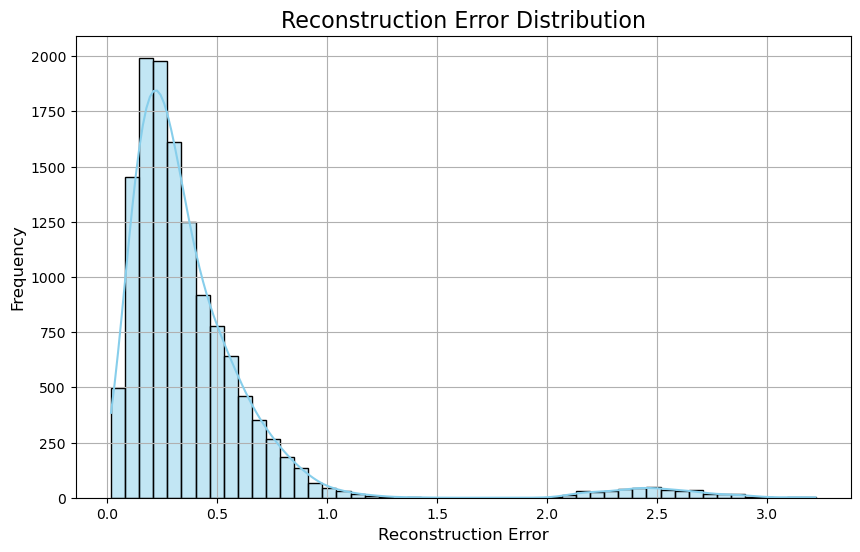

In [11]:
# Visualize reconstruction error distribution
plt.figure(figsize=(10, 6))
sns.histplot(reconstruction_error, bins=50, kde=True, color='skyblue')
plt.title('Reconstruction Error Distribution', fontsize=16)
plt.xlabel('Reconstruction Error', fontsize=12)
plt.ylabel('Frequency', fontsize=12)
plt.grid(True)
plt.show()


## Threshold Experimentation

We experiment with different thresholds for anomaly detection and observe how the number of detected anomalies changes. This helps us tune the sensitivity of the anomaly detection system.


Number of detected anomalies: 655
Threshold: 0.6926 | Number of anomalies: 1310


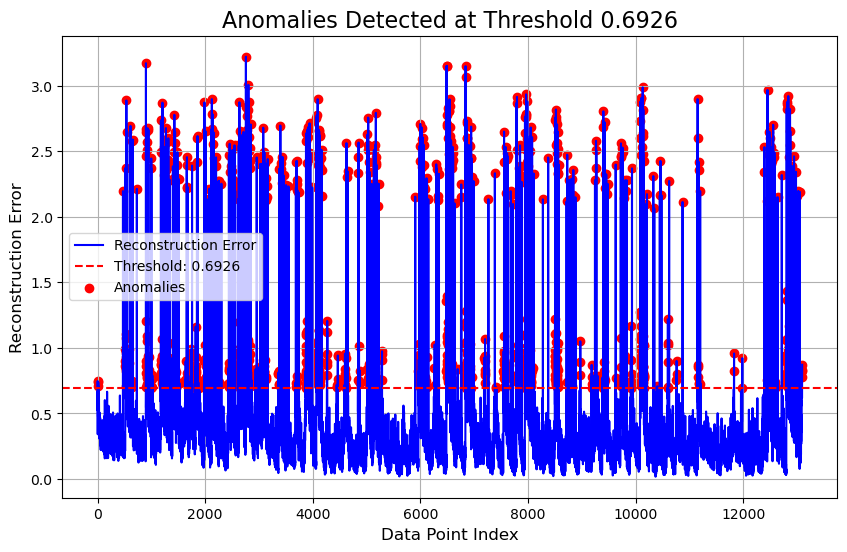

Threshold: 0.8710 | Number of anomalies: 655


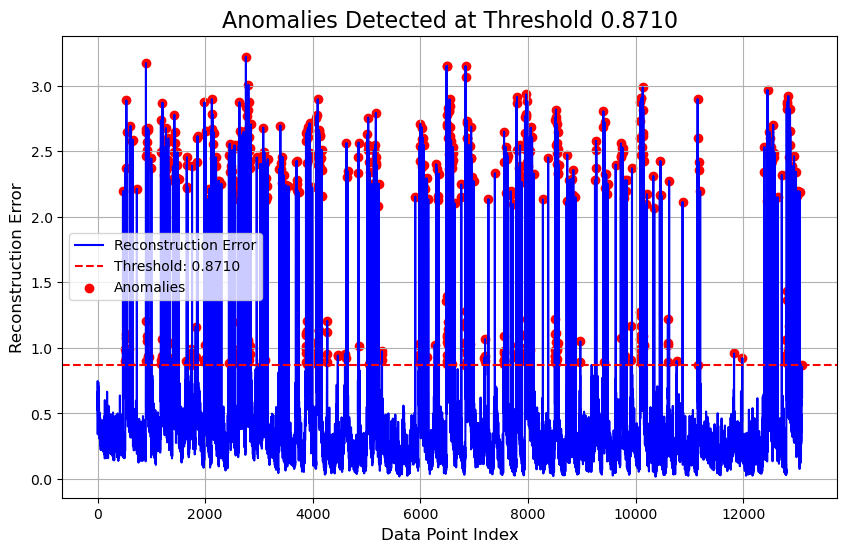

Threshold: 1.3987 | Number of anomalies: 393


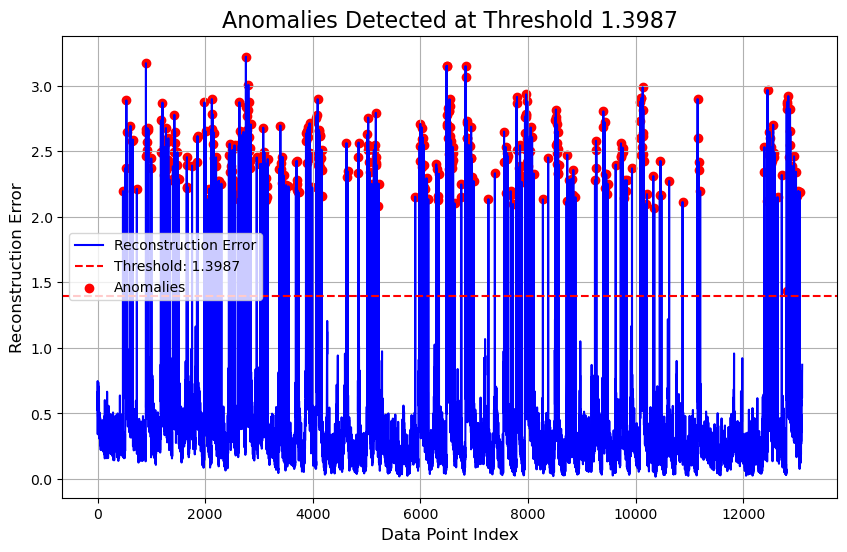

Threshold: 2.5692 | Number of anomalies: 131


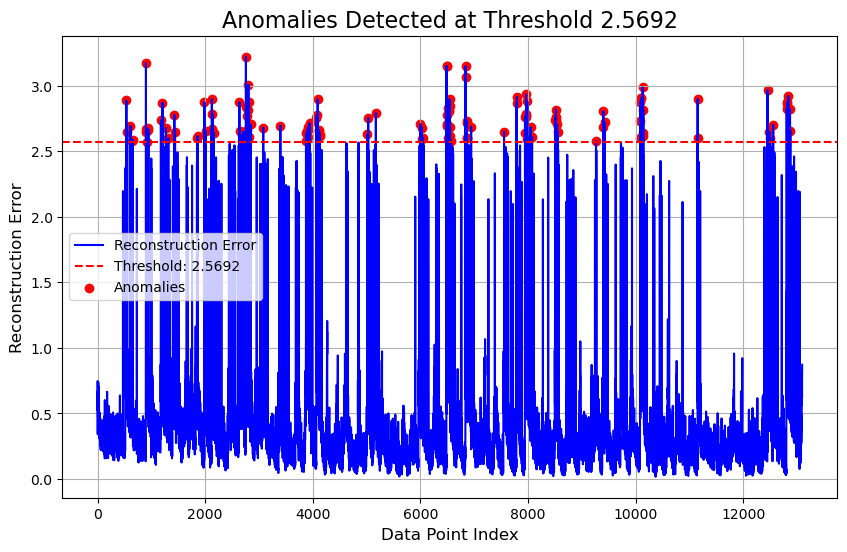

In [12]:
# Set a threshold for anomaly detection based on reconstruction error
threshold = np.percentile(reconstruction_error, 95)  # 95th percentile as an example
anomalies = reconstruction_error > threshold

print(f'Number of detected anomalies: {np.sum(anomalies)}')

# Experiment with different thresholds
thresholds = [np.percentile(reconstruction_error, p) for p in [90, 95, 97, 99]]
for th in thresholds:
    anomalies = reconstruction_error > th
    print(f'Threshold: {th:.4f} | Number of anomalies: {np.sum(anomalies)}')
    
    # Plot the anomalies
    plt.figure(figsize=(10, 6))
    plt.plot(reconstruction_error, label='Reconstruction Error', color='blue')
    plt.axhline(y=th, color='red', linestyle='--', label=f'Threshold: {th:.4f}')
    plt.scatter(np.where(anomalies)[0], reconstruction_error[anomalies], color='red', label='Anomalies')
    plt.title(f'Anomalies Detected at Threshold {th:.4f}', fontsize=16)
    plt.xlabel('Data Point Index', fontsize=12)
    plt.ylabel('Reconstruction Error', fontsize=12)
    plt.legend()
    plt.grid(True)
    plt.show()


## Conclusion

In this project, we successfully built an autoencoder model to detect anomalies in industrial equipment data. By experimenting with different thresholds, we were able to fine-tune the model's sensitivity to anomalies. Future work could involve testing the model on other datasets or further tuning the model architecture for improved performance.
